In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from glob import glob

import numpy as np
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import get_sa_scores, is_in_pubchem, is_valid
from gptchem.plotsettings import *
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

In [3]:
all_res = glob("out/*/*.pkl")

In [4]:
len(all_res)

28

In [5]:
compiled_res = []
generated_smiles = set()
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:
        try:
            generated_smiles = [s.split()[0] for s in temp_res["generated_smiles"]]
            in_train_smiles = []
            novel_indices = []
            for i, s in enumerate(temp_res["valid_smiles"]):
                s = s.split()[0]
                if s in temp_res["train_smiles"].values:
                    in_train_smiles.append(s)
                else:
                    novel_indices.append(i)

            metrics = {
                "noise_level": res["noise_level"],
                "temp": temp_res["temperature"],
                "frac_valid": temp_res["frac_valid"],
                "frac_unique": temp_res["frac_unique"],
                "frac_smiles_in_train": len(in_train_smiles) / len(temp_res["valid_smiles"]),
                "frac_smiles_in_pubchem": sum(
                    [is_in_pubchem(s.split()[0]) for s in temp_res["valid_smiles"]]
                )
                / len(temp_res["valid_smiles"]),
                "kld": temp_res["kld"],
                "frechet_d": temp_res["frechet_d"],
                "frechet_score": temp_res["frechet_score"],
                "train_size": res["train_size"],
            }
            valid_smiles = [s for s in generated_smiles if is_valid(s)]

            metrics["sa_score"] = np.mean(get_sa_scores(valid_smiles))

            v = [s for s in generated_smiles if is_valid(s)]
            generated_smiles_at_temp[temp_res["temperature"]].update(v)

            for me, v in temp_res["constrain_satisfaction"].items():
                metrics[me] = v

            compiled_res.append(metrics)

        except Exception as e:
            print(e)
            pass

'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
'PUGREST.B

In [12]:
compiled_res = pd.DataFrame(compiled_res)

In [13]:
grouped = compiled_res.groupby(["train_size", "temp"]).agg(["mean", "std", sem])

In [14]:
grouped_100 = grouped.loc[100]
grouped_300 = grouped.loc[300]
grouped_1000 = grouped.loc[1000]

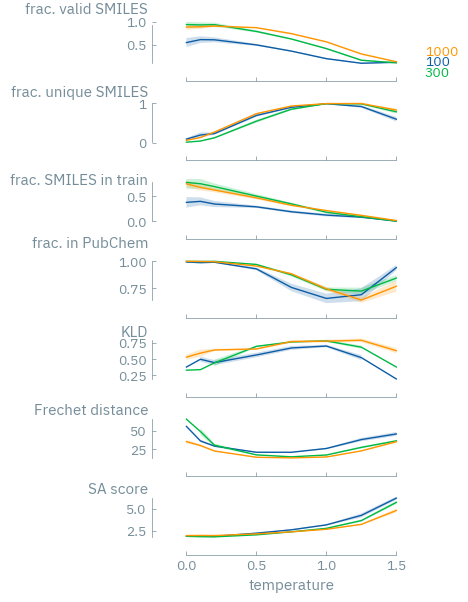

In [29]:
fig, ax = plt.subplots(7, 1, sharex="col", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
ax[0].plot(grouped_100.index, grouped_100["frac_valid"]["mean"], label="100")
ax[0].fill_between(
    grouped_100.index,
    grouped_100["frac_valid"]["mean"] - grouped_100["frac_valid"]["sem"],
    grouped_100["frac_valid"]["mean"] + grouped_100["frac_valid"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. valid SMILES", ax=ax[0], x_pad=0.05, y_pad=-0.02)


ax[1].plot(grouped_100.index, grouped_100["frac_unique"]["mean"], label="frac_unique")
ax[1].fill_between(
    grouped_100.index,
    grouped_100["frac_unique"]["mean"] - grouped_100["frac_unique"]["sem"],
    grouped_100["frac_unique"]["mean"] + grouped_100["frac_unique"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. unique SMILES", ax=ax[1], y_pad=0.05)

ax[2].plot(
    grouped_100.index, grouped_100["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train"
)
ax[2].fill_between(
    grouped_100.index,
    grouped_100["frac_smiles_in_train"]["mean"] - grouped_100["frac_smiles_in_train"]["sem"],
    grouped_100["frac_smiles_in_train"]["mean"] + grouped_100["frac_smiles_in_train"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in train", ax=ax[2], x_pad=0.05)


ax[3].plot(
    grouped_100.index, grouped_100["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem"
)
ax[3].fill_between(
    grouped_100.index,
    grouped_100["frac_smiles_in_pubchem"]["mean"] - grouped_100["frac_smiles_in_pubchem"]["sem"],
    grouped_100["frac_smiles_in_pubchem"]["mean"] + grouped_100["frac_smiles_in_pubchem"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. in PubChem", ax=ax[3], x_pad=0.05, y_pad=0.05)


ax[4].plot(grouped_100.index, grouped_100["kld"]["mean"], label="kld")
ax[4].fill_between(
    grouped_100.index,
    grouped_100["kld"]["mean"] - grouped_100["kld"]["sem"],
    grouped_100["kld"]["mean"] + grouped_100["kld"]["sem"],
    alpha=0.2,
)

ylabel_top("KLD", ax=ax[4], x_pad=0.05, y_pad=0.35)


ax[5].plot(grouped_100.index, grouped_100["frechet_d"]["mean"], label="frechet_d")
ax[5].fill_between(
    grouped_100.index,
    grouped_100["frechet_d"]["mean"] - grouped_100["frechet_d"]["sem"],
    grouped_100["frechet_d"]["mean"] + grouped_100["frechet_d"]["sem"],
    alpha=0.2,
)

ylabel_top("Frechet distance", ax=ax[5], x_pad=0.05, y_pad=0.35)


ax[6].plot(grouped_100.index, grouped_100["sa_score"]["mean"], label="frechet_score")
ax[6].fill_between(
    grouped_100.index,
    grouped_100["sa_score"]["mean"] - grouped_100["sa_score"]["sem"],
    grouped_100["sa_score"]["mean"] + grouped_100["sa_score"]["sem"],
    alpha=0.2,
)

ylabel_top("SA score", ax=ax[6], x_pad=0.05)


ax[-1].set_xlabel("temperature", labelpad=4)

ax[0].plot(grouped_300.index, grouped_300["frac_valid"]["mean"], label="300")
ax[0].fill_between(
    grouped_300.index,
    grouped_300["frac_valid"]["mean"] - grouped_300["frac_valid"]["sem"],
    grouped_300["frac_valid"]["mean"] + grouped_300["frac_valid"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. valid SMILES", ax=ax[0], x_pad=0.05, y_pad=-0.02)


ax[1].plot(grouped_300.index, grouped_300["frac_unique"]["mean"], label="frac_unique")
ax[1].fill_between(
    grouped_300.index,
    grouped_300["frac_unique"]["mean"] - grouped_300["frac_unique"]["sem"],
    grouped_300["frac_unique"]["mean"] + grouped_300["frac_unique"]["sem"],
    alpha=0.2,
)


ylabel_top("frac. unique SMILES", ax=ax[1], x_pad=0.05)

ax[2].plot(
    grouped_300.index, grouped_300["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train"
)
ax[2].fill_between(
    grouped_300.index,
    grouped_300["frac_smiles_in_train"]["mean"] - grouped_300["frac_smiles_in_train"]["sem"],
    grouped_300["frac_smiles_in_train"]["mean"] + grouped_300["frac_smiles_in_train"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in train", ax=ax[2], x_pad=0.05)


ax[3].plot(
    grouped_300.index, grouped_300["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem"
)
ax[3].fill_between(
    grouped_300.index,
    grouped_300["frac_smiles_in_pubchem"]["mean"] - grouped_300["frac_smiles_in_pubchem"]["sem"],
    grouped_300["frac_smiles_in_pubchem"]["mean"] + grouped_300["frac_smiles_in_pubchem"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. in PubChem", ax=ax[3], x_pad=0.05, y_pad=0.05)


ax[4].plot(grouped_300.index, grouped_300["kld"]["mean"], label="kld")
ax[4].fill_between(
    grouped_300.index,
    grouped_300["kld"]["mean"] - grouped_300["kld"]["sem"],
    grouped_300["kld"]["mean"] + grouped_300["kld"]["sem"],
    alpha=0.2,
)

ylabel_top("KLD", ax=ax[4], x_pad=0.05, y_pad=0.35)


ax[5].plot(grouped_300.index, grouped_300["frechet_d"]["mean"], label="frechet_d")
ax[5].fill_between(
    grouped_300.index,
    grouped_300["frechet_d"]["mean"] - grouped_300["frechet_d"]["sem"],
    grouped_300["frechet_d"]["mean"] + grouped_300["frechet_d"]["sem"],
    alpha=0.2,
)

ylabel_top("Frechet distance", ax=ax[5], x_pad=0.05, y_pad=0.35)


ax[6].plot(grouped_300.index, grouped_300["sa_score"]["mean"], label="frechet_score")
ax[6].fill_between(
    grouped_300.index,
    grouped_300["sa_score"]["mean"] - grouped_300["sa_score"]["sem"],
    grouped_300["sa_score"]["mean"] + grouped_300["sa_score"]["sem"],
    alpha=0.2,
)

ylabel_top("SA score", ax=ax[6], x_pad=0.05)


ax[-1].set_xlabel("temperature", labelpad=4)

ax[0].plot(grouped_1000.index, grouped_1000["frac_valid"]["mean"], label="1000")
ax[0].fill_between(
    grouped_1000.index,
    grouped_1000["frac_valid"]["mean"] - grouped_1000["frac_valid"]["sem"],
    grouped_1000["frac_valid"]["mean"] + grouped_1000["frac_valid"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. valid SMILES", ax=ax[0], x_pad=0.05, y_pad=-0.02)


ax[1].plot(grouped_1000.index, grouped_1000["frac_unique"]["mean"], label="frac_unique")
ax[1].fill_between(
    grouped_1000.index,
    grouped_1000["frac_unique"]["mean"] - grouped_1000["frac_unique"]["sem"],
    grouped_1000["frac_unique"]["mean"] + grouped_1000["frac_unique"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. unique SMILES", ax=ax[1], x_pad=0.05, y_pad=0.15)

ax[2].plot(
    grouped_1000.index, grouped_1000["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train"
)
ax[2].fill_between(
    grouped_1000.index,
    grouped_1000["frac_smiles_in_train"]["mean"] - grouped_1000["frac_smiles_in_train"]["sem"],
    grouped_1000["frac_smiles_in_train"]["mean"] + grouped_1000["frac_smiles_in_train"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in train", ax=ax[2], x_pad=0.05, y_pad=0.15)


ax[3].plot(
    grouped_1000.index,
    grouped_1000["frac_smiles_in_pubchem"]["mean"],
    label="frac_smiles_in_pubchem",
)
ax[3].fill_between(
    grouped_1000.index,
    grouped_1000["frac_smiles_in_pubchem"]["mean"] - grouped_1000["frac_smiles_in_pubchem"]["sem"],
    grouped_1000["frac_smiles_in_pubchem"]["mean"] + grouped_1000["frac_smiles_in_pubchem"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. in PubChem", ax=ax[3], x_pad=0.05, y_pad=0.05)


ax[4].plot(grouped_1000.index, grouped_1000["kld"]["mean"], label="kld")
ax[4].fill_between(
    grouped_1000.index,
    grouped_1000["kld"]["mean"] - grouped_1000["kld"]["sem"],
    grouped_1000["kld"]["mean"] + grouped_1000["kld"]["sem"],
    alpha=0.2,
)

ylabel_top("KLD", ax=ax[4], x_pad=0.05, y_pad=-0.05)


ax[5].plot(grouped_1000.index, grouped_1000["frechet_d"]["mean"], label="frechet_d")
ax[5].fill_between(
    grouped_1000.index,
    grouped_1000["frechet_d"]["mean"] - grouped_1000["frechet_d"]["sem"],
    grouped_1000["frechet_d"]["mean"] + grouped_1000["frechet_d"]["sem"],
    alpha=0.2,
)

ylabel_top("Frechet distance", ax=ax[5], x_pad=0.05, y_pad=0.15)


ax[6].plot(grouped_1000.index, grouped_1000["sa_score"]["mean"], label="frechet_score")
ax[6].fill_between(
    grouped_1000.index,
    grouped_1000["sa_score"]["mean"] - grouped_1000["sa_score"]["sem"],
    grouped_1000["sa_score"]["mean"] + grouped_1000["sa_score"]["sem"],
    alpha=0.2,
)

ylabel_top("SA score", ax=ax[6], x_pad=0.05, y_pad=0.15)

range_frame(
    ax[0],
    grouped_300.index,
    np.stack(
        [
            grouped_100["frac_valid"]["mean"],
            grouped_300["frac_valid"]["mean"],
            grouped_1000["frac_valid"]["mean"],
        ]
    ),
)


range_frame(
    ax[1],
    grouped_300.index,
    np.stack(
        [
            grouped_100["frac_unique"]["mean"],
            grouped_300["frac_unique"]["mean"],
            grouped_1000["frac_unique"]["mean"],
        ]
    ),
)

range_frame(
    ax[2],
    grouped_300.index,
    np.stack(
        [
            grouped_100["frac_smiles_in_train"]["mean"],
            grouped_300["frac_smiles_in_train"]["mean"],
            grouped_1000["frac_smiles_in_train"]["mean"],
        ]
    ),
)

range_frame(
    ax[3],
    grouped_300.index,
    np.stack(
        [
            grouped_100["frac_smiles_in_pubchem"]["mean"],
            grouped_300["frac_smiles_in_pubchem"]["mean"],
            grouped_1000["frac_smiles_in_pubchem"]["mean"],
        ]
    ),
)


range_frame(
    ax[4],
    grouped_300.index,
    np.nan_to_num(
        np.stack(
            [
                grouped_100["kld"]["mean"],
                grouped_300["kld"]["mean"],
                grouped_1000["kld"]["mean"],
            ]
        ),
        0.5,
    ),
)

range_frame(
    ax[5],
    grouped_300.index,
    np.nan_to_num(
        np.stack(
            [
                grouped_100["frechet_d"]["mean"],
                grouped_300["frechet_d"]["mean"],
                grouped_1000["frechet_d"]["mean"],
            ]
        ),
        10,
    ),
)


range_frame(
    ax[6],
    grouped_300.index,
    np.stack(
        [
            grouped_100["sa_score"]["mean"],
            grouped_300["sa_score"]["mean"],
            grouped_1000["sa_score"]["mean"],
        ]
    ),
)


ax[-1].set_xlabel("temperature", labelpad=4)

matplotx.line_labels(ax[0])
plt.subplots_adjust(hspace=0.7, top=1, bottom=0.2)

fig.savefig("random_homo_lumo_gap_small_one_digit.pdf", bbox_inches="tight")

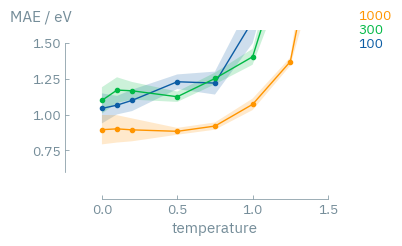

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))


ax.plot(grouped_100.index, grouped_100["mean_absolute_error"]["mean"], marker="o", label="100")
ax.fill_between(
    grouped_100.index,
    grouped_100["mean_absolute_error"]["mean"] - grouped_100["mean_absolute_error"]["sem"],
    grouped_100["mean_absolute_error"]["mean"] + grouped_100["mean_absolute_error"]["sem"],
    alpha=0.2,
)

ax.plot(grouped_300.index, grouped_300["mean_absolute_error"]["mean"], marker="o", label="300")
ax.fill_between(
    grouped_300.index,
    grouped_300["mean_absolute_error"]["mean"] - grouped_300["mean_absolute_error"]["sem"],
    grouped_300["mean_absolute_error"]["mean"] + grouped_300["mean_absolute_error"]["sem"],
    alpha=0.2,
)


ax.plot(grouped_1000.index, grouped_1000["mean_absolute_error"]["mean"], marker="o", label="1000")
ax.fill_between(
    grouped_1000.index,
    grouped_1000["mean_absolute_error"]["mean"] - grouped_1000["mean_absolute_error"]["sem"],
    grouped_1000["mean_absolute_error"]["mean"] + grouped_1000["mean_absolute_error"]["sem"],
    alpha=0.2,
)

range_frame(ax, np.array([0, 1.5]), np.array([0.6, 1.5]))

matplotx.line_labels(ax)

ax.set_xlabel("temperature")
ylabel_top("MAE / eV", ax=ax)
fig.savefig("random_smiles_homo_lumo_mae_small_one_digit.pdf", bbox_inches="tight")